#### Tesis Magister Ingeniería Industrial
#### Autor: Kathyana Pérez

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.ensemble import RandomForestRegressor
from datetime import datetime, timedelta 

In [125]:
import os
from keras.layers import Dense, Dropout, Flatten, Reshape, LSTM
from keras.models import Sequential
from keras.layers import Dense

In [24]:
#generar datos basados en la media para predecir dias posteriores
def dias_extras(datos,dias_medias=30,dias_generar=20):

    aux = list(datos)
    for dia in np.arange(dias_generar):
        calculo = list(aux[-dias_medias:])
        aux.append(int(np.floor(np.mean(calculo))))
    return np.array(aux)

## Preprocesamiento Datos

## Instancia 3: Región Metropolitana

#### A. Pacientes en UCI

In [27]:
# UCI, producto 8
arch_p8 = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto8/UCI.csv'
df_uci = pd.read_csv(arch_p8)
df_uci = df_uci.iloc[6][3:] # Región Metropolitana
df_uci = df_uci.to_frame().reset_index().rename(columns={'index': 'dates', 6:'hospitalisations'})

Text(0.5, 1.0, 'Pacientes en unidad UCI COVID por día en la región Metropolitana')

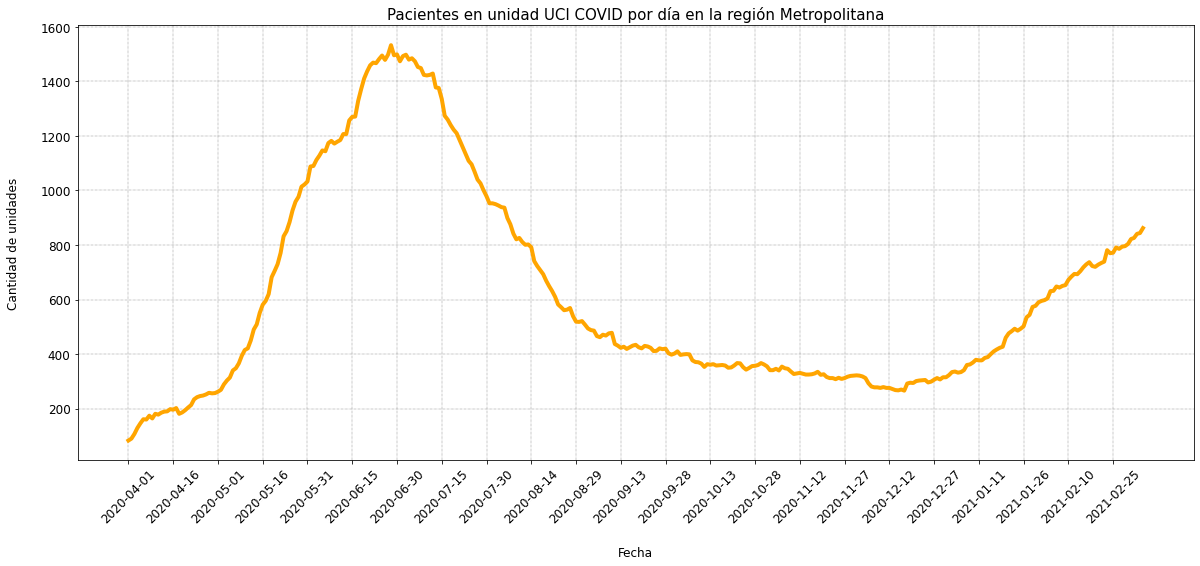

In [28]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.plot(df_uci.dates.values,df_uci.hospitalisations.values,linewidth=4, color = 'orange')
plt.xticks(df_uci.dates.values[::15],rotation=45,fontsize=12)
plt.yticks(fontsize=12)
plt.grid(color='grey', ls = '-.', lw = 0.40)
plt.xlabel('Fecha', labelpad = 20, fontsize=12)
plt.ylabel('Cantidad de unidades',labelpad = 20,fontsize=12)
plt.title("Pacientes en unidad UCI COVID por día en la región Metropolitana",fontsize=15)

#### B. Examenes PCR

In [30]:
# PCR realizados, producto 7
arch_p7 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto7/PCR.csv"
pcr = pd.read_csv(arch_p7)
pcr = pcr.iloc[6][3:] # Región Metropolitana
pcr = pcr.to_frame().reset_index().rename(columns={'index': 'fecha', 6:'pcr'})

# Positividad, producto 55
arch_p55 = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto55/Positividad_por_region.csv'
positividad = pd.read_csv(arch_p55)
positividad = positividad[positividad['Region'] == 'Metropolitana'].reset_index(drop = True).drop(['Region','Codigo region','region_residencia'], axis=1)

# Unir Datos
pcr_positivo = pcr.merge(positividad)

# positividad = test positivos / test totales
pcr_positivo["positivos"] = pcr_positivo["pcr"] * pcr_positivo["positividad"]

#los valores NA de la columna positivos seran '0'
pcr_positivo["positivos"] = pcr_positivo["positivos"].fillna(0).astype(int)
pcr_positivo["pcr"] = pcr_positivo["pcr"].fillna(0).astype(int)

Text(0.5, 1.0, 'PCR en Región Metropolitana por día')

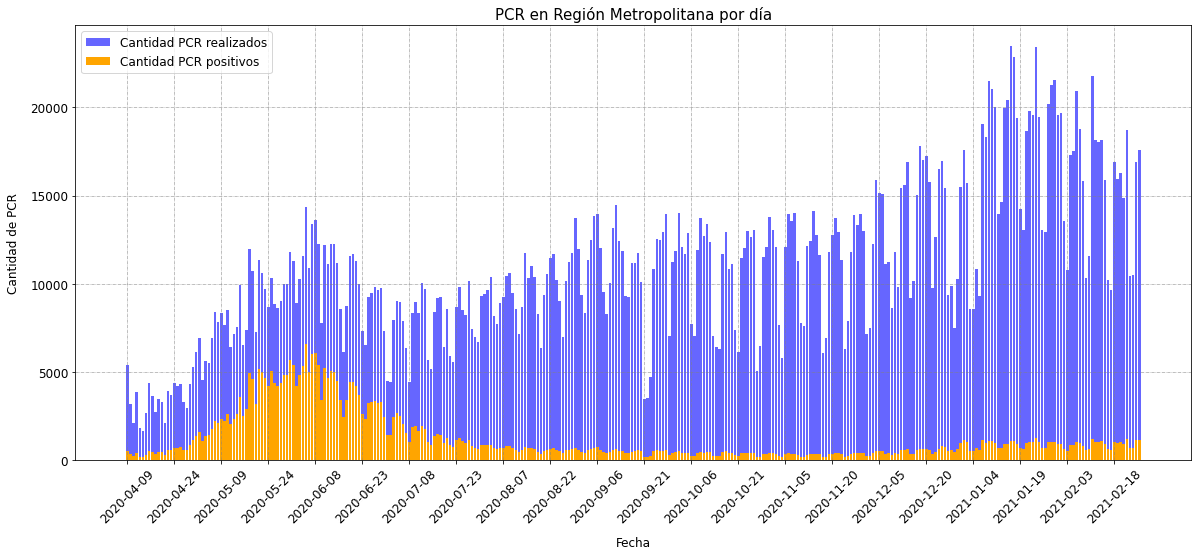

In [31]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.bar(pcr_positivo['fecha'], pcr_positivo['pcr'], label = 'Cantidad PCR realizados',  alpha=0.6, color = 'blue')
plt.bar(pcr_positivo['fecha'], pcr_positivo['positivos'], label = 'Cantidad PCR positivos', color = 'orange')
plt.xticks(pcr_positivo['fecha'][::15],rotation=45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 12)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.xlabel('Fecha',  labelpad = 10, fontsize = 12)
plt.ylabel('Cantidad de PCR',labelpad = 10, fontsize = 12)
plt.title('PCR en Región Metropolitana por día', fontsize = 15)
# plt.savefig('pcr_versus.png',bbox_inches = "tight")

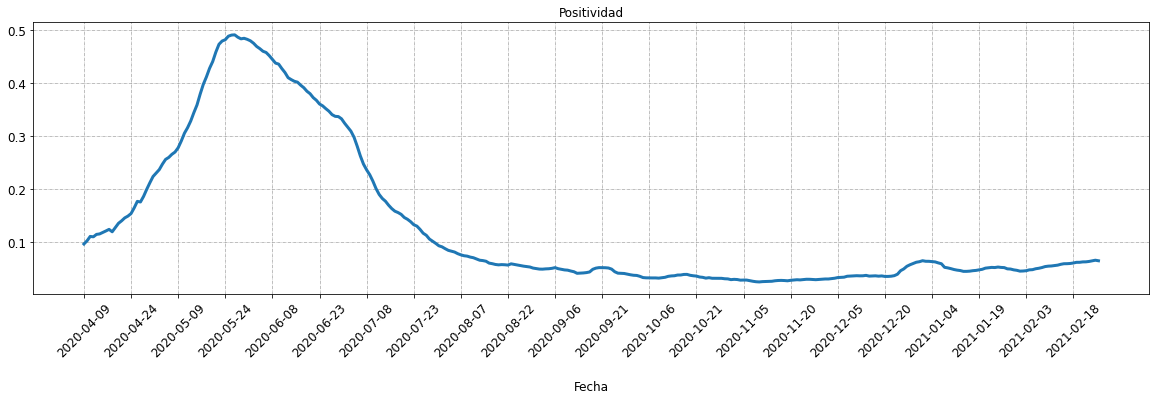

In [32]:
# Grafico positividad
plt.figure(figsize=(20,5))
plt.plot(pcr_positivo['fecha'], pcr_positivo['positividad'], linewidth = 3)
plt.xticks(pcr_positivo['fecha'][::15],rotation=45, fontsize = 12)
plt.yticks(fontsize = 12)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.xlabel('Fecha',  labelpad = 20, fontsize = 12)
# plt.ylabel(labelpad = 20, fontsize = 20)
plt.title('Positividad Región Biobío', fontsize = 12)
plt.savefig('positividad.png',bbox_inches = "tight")

#### C. Camas Disponibles

In [33]:
# Camas UCI, producto 58
arch_p58 = "https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto58/Camas_UCI_diarias.csv"
camas = pd.read_csv(arch_p58)

# Metropolitana
camas_covid    = camas.iloc[23][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 23:'camas ocupadas covid'}) # Biobio
camas_no_covid = camas.iloc[40][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 40:'camas ocupadas no covid'})# Biobio
camas_total    = camas.iloc[6][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 6:'total camas'})
camas_ocupadas = camas.iloc[57][2:].to_frame().reset_index().rename(columns={'index': 'fecha', 57:'total camas ocupadas'})

In [34]:
camas_disponibles = pd.DataFrame()
camas_disponibles['fecha'] = camas_total['fecha']
camas_disponibles['camas disponibles'] = camas_total['total camas'].values - camas_ocupadas['total camas ocupadas'].values

Text(0.5, 1.0, 'Distribución de camas UCI en la región Metropolitana')

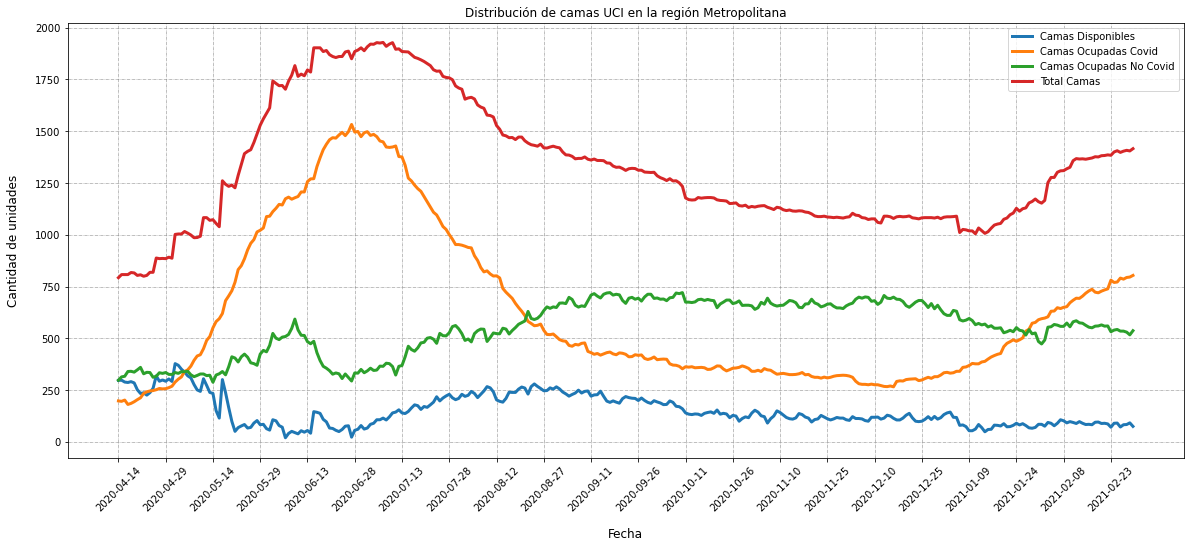

In [35]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.plot(camas_disponibles['fecha'].values , camas_disponibles['camas disponibles'].values,label = "Camas Disponibles",linewidth = 3)
plt.plot(camas_covid['fecha'].values , camas_covid['camas ocupadas covid'].values,label ='Camas Ocupadas Covid',linewidth = 3)
plt.plot(camas_no_covid['fecha'].values , camas_no_covid['camas ocupadas no covid'].values,label ='Camas Ocupadas No Covid',linewidth = 3)
plt.plot(camas_total['fecha'].values , camas_total['total camas'].values,label ='Total Camas',linewidth = 3)
plt.xticks(camas_total['fecha'].values[::15],rotation=45)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.legend()
plt.xlabel('Fecha', labelpad = 15, fontsize = 12)
plt.ylabel('Cantidad de unidades',labelpad = 15,fontsize = 12)
plt.title('Distribución de camas UCI en la región Metropolitana', fontsize = 12)
# plt.savefig("camas_biobio.png")

#### D. Fallecidos

In [36]:
# Defunciones, producto 14
arch_p14 = 'https://raw.githubusercontent.com/MinCiencia/Datos-COVID19/master/output/producto14/FallecidosCumulativo.csv'
defunciones = pd.read_csv(arch_p14)

# Metropolitana
df_fallecidos = defunciones[defunciones['Region'] == 'Metropolitana'].reset_index(drop=True).drop(['Region'], axis=1)

# Sacar acumulativos
fallecidos = df_fallecidos.values[0]
resultados = fallecidos[1:]-fallecidos[:-1]
resultados[resultados<0] = 0
resultados = list(resultados)
resultados.insert(0,0)
fallecidos = pd.DataFrame()
fallecidos["fechas"] = df_fallecidos.columns
fallecidos["fallecidos"] = np.array(resultados)

#Para grafica
df_fallecidos = df_fallecidos.T.reset_index().rename(columns={'index': 'fecha', 0:'total acumulados'})

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Fallecidos en la región Metropolitana')

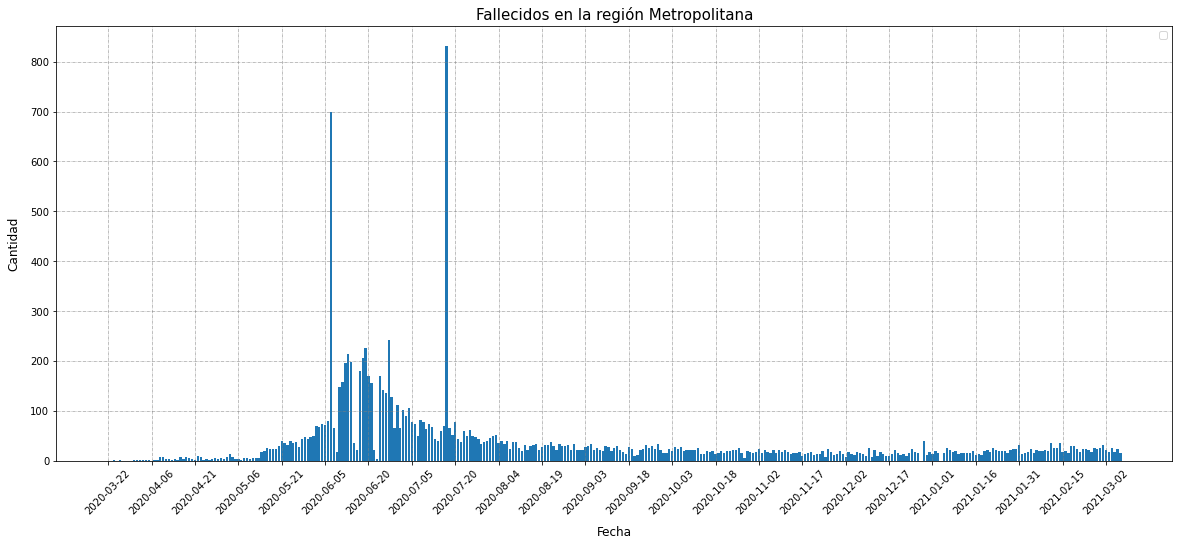

In [39]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.bar(fallecidos.fechas.values,fallecidos.fallecidos.values)
# plt.plot(df_fallecidos.fecha, df_fallecidos['total acumulados'].values)
plt.xticks(fallecidos.fechas.values[::15],rotation=45)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.legend()
plt.xlabel('Fecha', labelpad = 10, fontsize = 12)
plt.ylabel('Cantidad',labelpad = 10,fontsize = 12)
plt.title('Fallecidos en la región Metropolitana', fontsize = 15)

#### E. Cuarentena

In [40]:
# Datos cargado wikipedia
# Revisar codigo computo cuarentena
wiki = r'E:\Udec\Magister\Tesis\Modelo\Modelo Kathyanistico\cuarentena_metropolitana.csv'
cuarentena = pd.read_csv(wiki).drop(['Unnamed: 0'], axis = 1).rename(columns={"por_cuarenta": "Porcentaje Cuarentena"})

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Porcentaje de cuarentena en Metropolitana ')

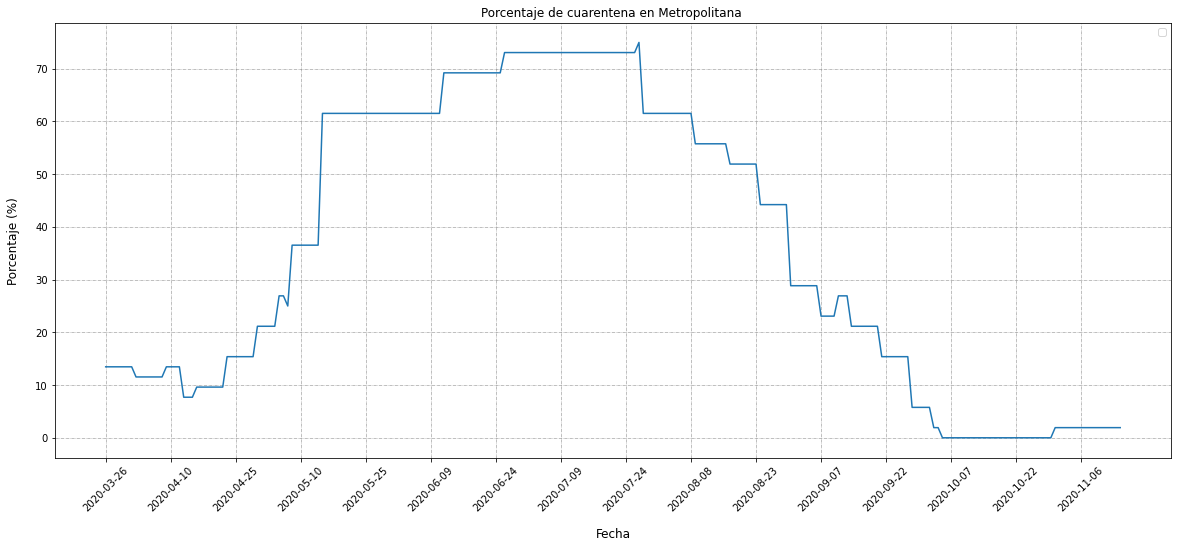

In [41]:
# Grafico imagen
plt.figure(figsize=(20,8))
plt.plot(cuarentena.fechas.values,cuarentena['Porcentaje Cuarentena'].values)
plt.xticks(cuarentena.fechas.values[::15],rotation=45)
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.legend()
plt.xlabel('Fecha', labelpad = 15, fontsize = 12)
plt.ylabel('Porcentaje (%)',labelpad = 15,fontsize = 12)
plt.title('Porcentaje de cuarentena en Metropolitana ', fontsize = 12)

## Modelo

In [42]:
# Iniciamos semilla, para generar los mismos datos aleatorios para cada ejecucion
seed= 42

#### 1. Visualizacion de datos

In [43]:
pcr_positivo = pcr_positivo.rename({"fecha": "fechas"},axis=1)
df_uci       = df_uci.rename({"dates": "fechas", "hospitalisations":"hospitalizaciones"},axis=1)
camas_total  = camas_total.rename({"fecha": "fechas"},axis=1)
camas_usadas = camas_covid.rename({"fecha": "fechas"},axis=1)
# fallecidos y cuarentena listo 

# Union de datos
datos = pd.merge(pd.merge(df_uci,camas_total),camas_usadas)
datos = pd.merge(pd.merge(pcr_positivo,datos),fallecidos)
datos = pd.merge(datos,cuarentena)

In [73]:
# object a enteros
datos['hospitalizaciones']= datos['hospitalizaciones'].astype(int)
datos['total camas']= datos['total camas'].astype(int)
datos['camas ocupadas covid']= datos['camas ocupadas covid'].astype(int)

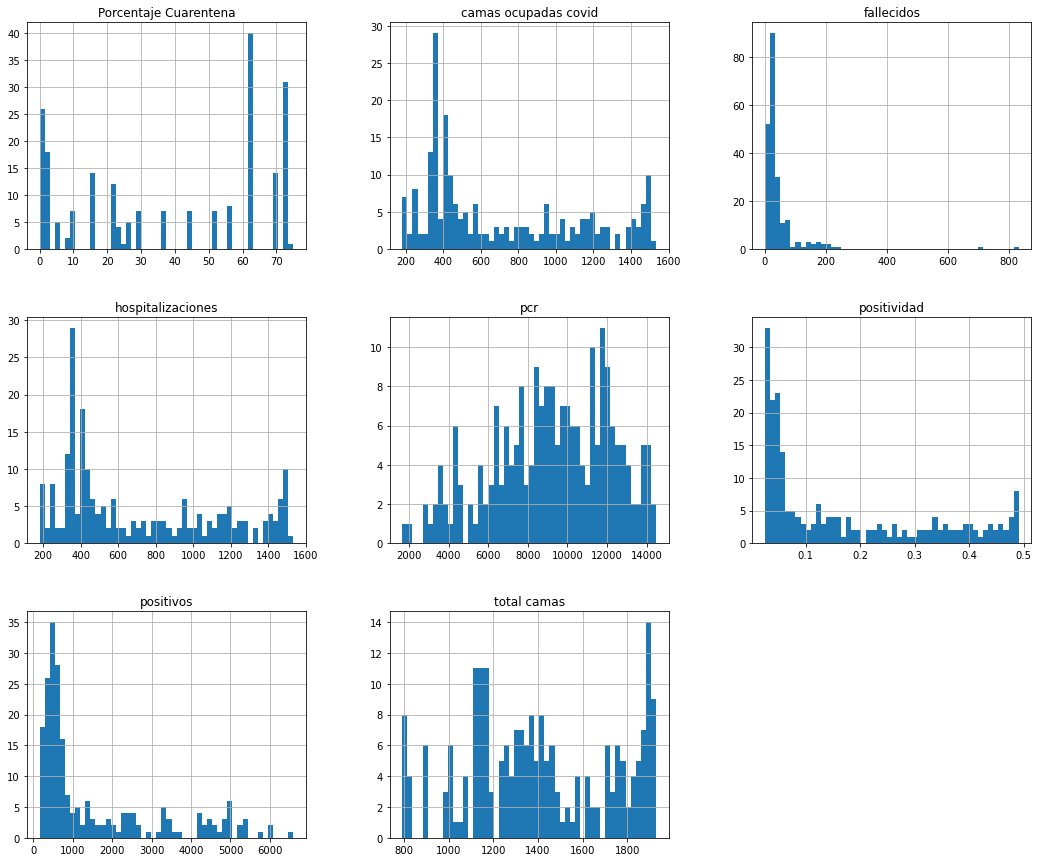

In [75]:
# Histograma
datos.hist(bins=50, figsize=(18,15))
plt.show()

In [76]:
# Matriz de datos
datos1 = datos.rename({"pcr": "PCR [x1]","positivos": "Positivos [x2]","total camas": "Total camas [x3]",
                      'camas ocupadas covid': "Camas usadas[x4]" , "fallecidos" : "Fallecidos [x5]",
                       "Porcentaje Cuarentena": "Porcentaje Cuarentena [x6]","hospitalizaciones":"Hospitalizaciones [y]" },axis=1)
datos1 = datos1[["fechas","PCR [x1]", "Positivos [x2]","Total camas [x3]", "Camas usadas[x4]" ,"Fallecidos [x5]", 
                 "Porcentaje Cuarentena [x6]","Hospitalizaciones [y]"]]
datos1

,fechas,PCR [x1],Positivos [x2],Total camas [x3],Camas usadas[x4],Fallecidos [x5],Porcentaje Cuarentena [x6],Hospitalizaciones [y]
0,2020-04-14,1656,192,793,198,4.0,7.692308,190
1,2020-04-15,2694,320,808,196,1.0,7.692308,198
2,2020-04-16,4356,529,808,202,7.0,9.615385,196
3,2020-04-17,3670,457,808,181,3.0,9.615385,202
4,2020-04-18,2744,329,818,186,7.0,9.615385,181
...,...,...,...,...,...,...,...,...
211,2020-11-11,7616,199,1121,331,21.0,1.923077,329
212,2020-11-12,12137,322,1117,328,18.0,1.923077,331
213,2020-11-13,12412,331,1120,325,13.0,1.923077,328
214,2020-11-14,14107,379,1115,325,15.0,1.923077,325


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000196A129E5C8>,
      dtype=object)

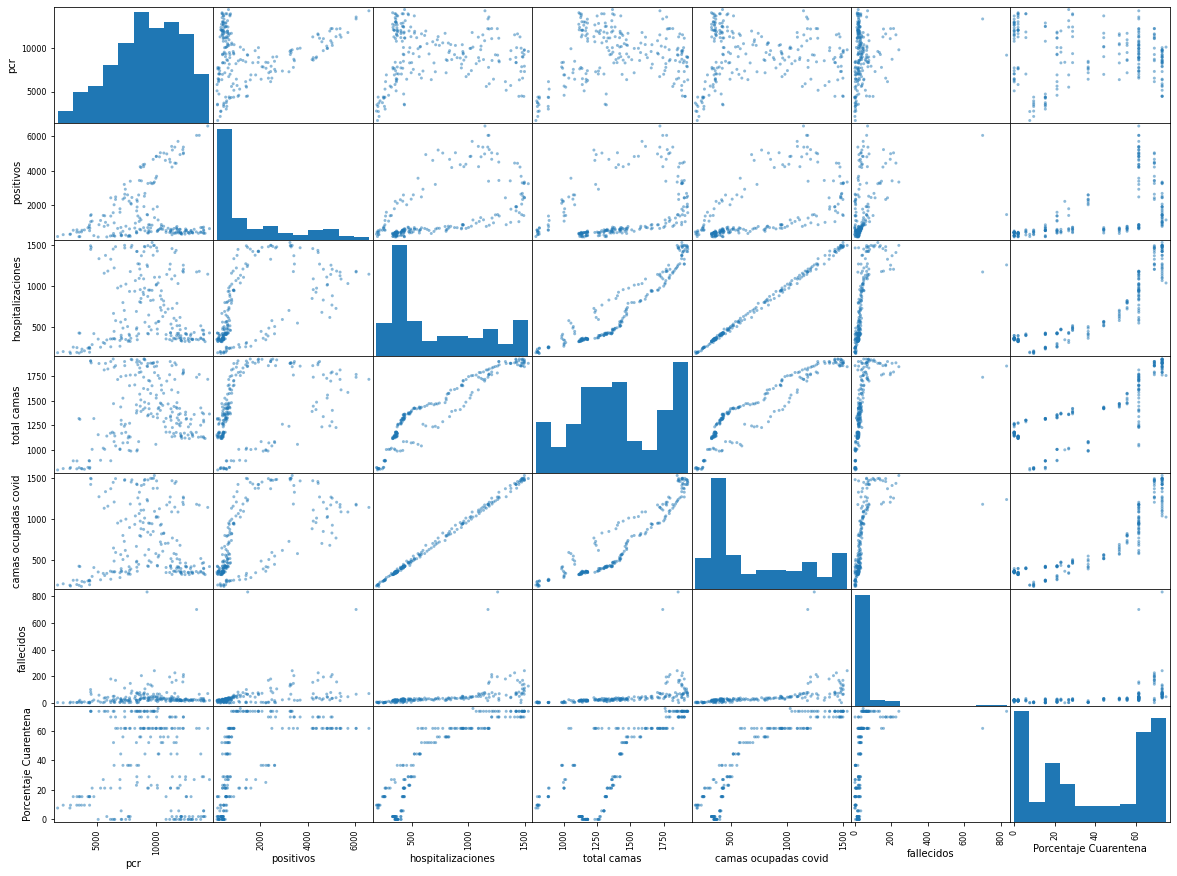

In [77]:
#Scatter Datos
atributos = ['pcr', 'positivos', 'hospitalizaciones','total camas','camas ocupadas covid','fallecidos', 'Porcentaje Cuarentena']
scatter_matrix(datos[atributos], figsize=(20, 15))
# save_fig("scatter_matrix_plot")

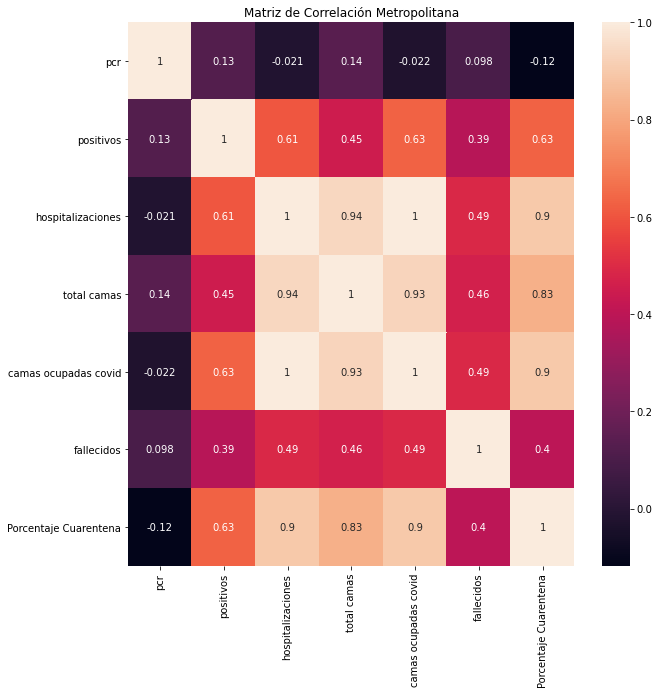

In [105]:
#Matriz Correlacion

import seaborn as sns 
correlacion = datos[atributos].corr()
plt.figure(figsize=(10,10))
plt.title('Matriz de Correlación Metropolitana')
sns.heatmap(correlacion, annot =True)

In [81]:
# Descripcion de datos
datos.describe()

,pcr,positividad,positivos,hospitalizaciones,total camas,camas ocupadas covid,fallecidos,Porcentaje Cuarentena
count,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000,216.000000
mean,9235.333333,0.171073,1535.583333,711.685185,1409.439815,712.314815,46.666667,38.034188
std,2962.575226,0.154035,1610.942547,416.499469,328.472159,415.809385,82.524246,27.783755
min,1656.000000,0.025666,165.000000,181.000000,793.000000,181.000000,1.000000,0.000000
25%,7257.000000,0.043093,442.750000,361.750000,1153.500000,361.750000,18.000000,9.615385
50%,9411.000000,0.095998,685.000000,518.500000,1368.000000,518.500000,25.000000,40.384615
75%,11668.750000,0.299933,2259.000000,1088.500000,1733.750000,1088.500000,44.000000,61.538462
max,14476.000000,0.490886,6591.000000,1533.000000,1929.000000,1533.000000,831.000000,75.000000


#### 2. Proyección

In [106]:
datos_grandes = datos.drop(["fechas"],axis=1).apply(dias_extras)
fechas = datos.fechas.values

fecha_base = datetime.strptime(fechas[-1], "%Y-%m-%d")
fechas_generadas = [(fecha_base + timedelta(days = int(dia))).strftime("%Y-%m-%d")  for dia in np.arange(1,20+1)]
fechas = np.concatenate([fechas,fechas_generadas])

datos_grandes["fechas"] = fechas
datos = datos_grandes.copy()

#### 3. Modelos

In [107]:
#Separamos caracteristicas de variables que se predeciran. 
# Se separo en x e y, "y" corresponde a la cantidad de hospitalizaciones predichas
y = datos["hospitalizaciones"].values
X = datos.drop(["hospitalizaciones","fechas"],axis=1).values

In [108]:
# se dividen los datos en conjunto de entrenamiento y de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)

##### A. Árbol de regresion

In [86]:
tree_reg = RandomForestRegressor(n_estimators = 10, random_state=42).fit(X_train, y_train)
# Obtiene la prediccion
y_pred = tree_reg .predict(X_test)

In [92]:
print('Resultados')
print("- r2_score", r2_score(y_test,y_pred))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test,y_pred)) 
print("- mean_squared_error", mean_squared_error(y_test,y_pred))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test,y_pred))
print("- median_absolute_error", median_absolute_error(y_test,y_pred))

Resultados
- r2_score 0.9968727683908125
- mean_absolute_error 14.223076923076913
- mean_squared_error 533.2379487179484
- mean_absolute_percentage_error 0.02283386597334118
- median_absolute_error 7.200000000000017


Text(0.5, 1.0, 'Resultado Árbol de Regresión Metropolitana')

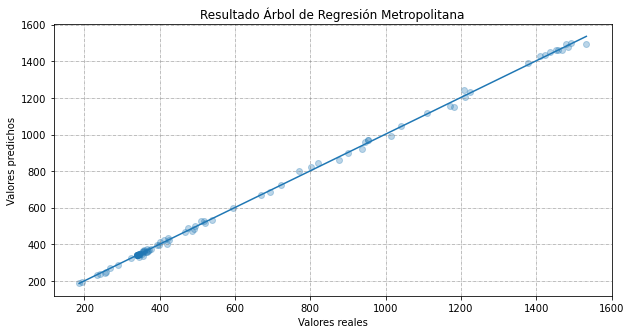

In [112]:
# Grafico Ajuste
plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred, alpha = 0.3)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.title('Resultado Árbol de Regresión Metropolitana')

##### B. Regresión Lineal

In [113]:
# Realiza la regresion lineal
reg = LinearRegression(n_jobs=-1).fit(X_train, y_train) # n_jobs=-1 utiliza todos los nucleos


# Obtiene la prediccion
y_pred = reg.predict(X_test)

In [114]:
print('Resultados')
print("- r2_score", r2_score(y_test,y_pred))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test,y_pred)) 
print("- mean_squared_error", mean_squared_error(y_test,y_pred))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test,y_pred))
print("- median_absolute_error", median_absolute_error(y_test,y_pred))

Resultados
- r2_score 0.9991520048731676
- mean_absolute_error 8.725039357856081
- mean_squared_error 142.4354942963051
- mean_absolute_percentage_error 0.014435264682075495
- median_absolute_error 6.373287370087382


Text(0.5, 1.0, 'Resultado Regresion Lineal Metropolitana')

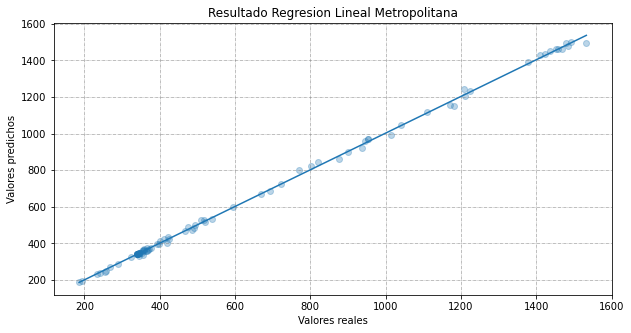

In [115]:
# Grafico Ajuste
plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred, alpha = 0.3)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.title('Resultado Regresion Lineal Metropolitana')

##### C. Elastic Net

In [117]:
regr = ElasticNet(random_state=seed).fit(X_train, y_train)
y_pred = regr.predict(X_test)

In [118]:
print('Resultados')
print("- r2_score", r2_score(y_test,y_pred))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test,y_pred)) 
print("- mean_squared_error", mean_squared_error(y_test,y_pred))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test,y_pred))
print("- median_absolute_error", median_absolute_error(y_test,y_pred))

Resultados
- r2_score 0.9991537652684994
- mean_absolute_error 8.462935237593694
- mean_squared_error 142.1398053573963
- mean_absolute_percentage_error 0.013522715693302144
- median_absolute_error 6.205631662792143


Text(0.5, 1.0, 'Resultado Elastic Net Metropolitana')

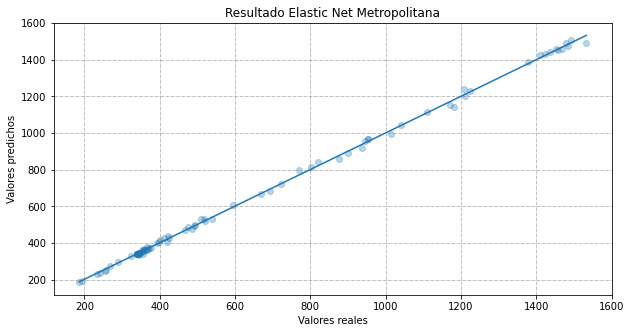

In [119]:
# Grafico Ajuste
plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred, alpha = 0.3)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.title('Resultado Elastic Net Metropolitana')

##### D. Red Neuronal


In [120]:
mlp = MLPRegressor(hidden_layer_sizes=(100,200,100),random_state=seed, max_iter=500,activation="tanh").fit(X_train, y_train)
y_pred = mlp.predict(X_test)

C:\Users\kathy\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [121]:
print('Resultados')
print("- r2_score", r2_score(y_test,y_pred))   #bondad del ajuste
print("- mean_absolute_error", mean_absolute_error(y_test,y_pred)) 
print("- mean_squared_error", mean_squared_error(y_test,y_pred))
print("- mean_absolute_percentage_error", mean_absolute_percentage_error(y_test,y_pred))
print("- median_absolute_error", median_absolute_error(y_test,y_pred))

Resultados
- r2_score -2.066423643847472
- mean_absolute_error 589.1448816644635
- mean_squared_error 515059.0535405084
- mean_absolute_percentage_error 0.8683506883831776
- median_absolute_error 361.72133188215025


Text(0.5, 1.0, 'Resultado Redes Neuronales Metropolitana')

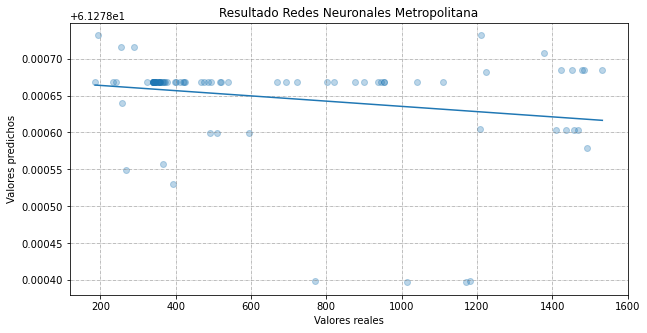

In [122]:
# Grafico Ajuste
plt.figure(figsize=(10,5))
plt.scatter(y_test,y_pred, alpha = 0.3)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, y_pred, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.title('Resultado Redes Neuronales Metropolitana')

In [123]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [124]:
scores

array([-1022.86      ,  -160.89117647,  -568.35      , -1154.77352941,
        -654.66411765,  -424.30352941,  -638.75176471,  -484.56588235,
        -526.89470588,  -761.16470588])

##### E. Serie de tiempo

In [164]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = r"E:\Udec\Magister\Tesis\Machine Learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "Images")
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [165]:
X,y,fechas  = datos.drop(["hospitalizaciones","fechas"],axis=1).values,datos["hospitalizaciones"].values,datos.fechas.values

In [128]:
def create_segments_and_labels(X,y, time_steps, step):
    from scipy import stats
    # x, y, z acceleration as features
    N_FEATURES = X.shape[1]
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(X) - time_steps, step):
        xs = X[i: i + time_steps,0]
        ys = X[i: i + time_steps,1]
        zs = X[i: i + time_steps,2]
        ws = X[i: i + time_steps,3]
        vs = X[i: i + time_steps,4]
        us = X[i: i + time_steps,5]
        # Retrieve the most often used label in this segment
        label = stats.mode(y[i: i + time_steps])[0][0]
        segments.append([xs, ys, zs, ws,vs, us])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [143]:
TIME_PERIODS = 1
STEP_DISTANCE =1
batch_size = 16
N_FEATURES =  X.shape[1]

input_shape = (TIME_PERIODS*N_FEATURES)
input_shape

# Dividir entre train y test
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
Xtrain, Xtest = X[0:train_size,:], X[train_size:len(X),:]
ytrain, ytest = y[0:train_size], y[train_size:len(X)]
fechas_train,fechas_test =  fechas[0:train_size], fechas[train_size:len(X)]

In [130]:
x_train, y_train = create_segments_and_labels(Xtrain,
                                              ytrain,
                                              TIME_PERIODS,
                                              STEP_DISTANCE
                                              )

x_test, y_test = create_segments_and_labels(Xtest,
                                              ytest,
                                              TIME_PERIODS,
                                              STEP_DISTANCE
                                              )

##### F. Perceptron

In [149]:
# create and fit Multilayer Perceptron model
model = Sequential()
model.add(Reshape((TIME_PERIODS, N_FEATURES), input_shape=(input_shape,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(80, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='relu'))
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1, 6)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 1, 50)             350       
_________________________________________________________________
dense_21 (Dense)             (None, 1, 80)             4080      
_________________________________________________________________
dense_22 (Dense)             (None, 1, 50)             4050      
_________________________________________________________________
dense_23 (Dense)             (None, 1, 25)             1275      
_________________________________________________________________
dense_24 (Dense)             (None, 1, 1)              26        
Total params: 9,781
Trainable params: 9,781
Non-trainable params: 0
____________________________________________________

In [150]:
model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer=optimizer)
history = model.fit(x_train, y_train, epochs=1000, batch_size=batch_size, verbose=2, 
#                     callbacks=callbacks_list
                   )

Epoch 1/1000
9/9 - 0s - loss: 209929.8125
Epoch 2/1000
9/9 - 0s - loss: 143340.2969
Epoch 3/1000
9/9 - 0s - loss: 103568.0547
Epoch 4/1000
9/9 - 0s - loss: 65992.4219
Epoch 5/1000
9/9 - 0s - loss: 31521.5742
Epoch 6/1000
9/9 - 0s - loss: 16788.7246
Epoch 7/1000
9/9 - 0s - loss: 11889.7812
Epoch 8/1000
9/9 - 0s - loss: 12028.9863
Epoch 9/1000
9/9 - 0s - loss: 7292.9424
Epoch 10/1000
9/9 - 0s - loss: 5493.6753
Epoch 11/1000
9/9 - 0s - loss: 4530.1069
Epoch 12/1000
9/9 - 0s - loss: 4316.3940
Epoch 13/1000
9/9 - 0s - loss: 3912.5427
Epoch 14/1000
9/9 - 0s - loss: 4350.8140
Epoch 15/1000
9/9 - 0s - loss: 5298.4287
Epoch 16/1000
9/9 - 0s - loss: 4497.3335
Epoch 17/1000
9/9 - 0s - loss: 3922.0000
Epoch 18/1000
9/9 - 0s - loss: 3244.8362
Epoch 19/1000
9/9 - 0s - loss: 3199.6448
Epoch 20/1000
9/9 - 0s - loss: 3437.1692
Epoch 21/1000
9/9 - 0s - loss: 2951.3789
Epoch 22/1000
9/9 - 0s - loss: 3477.9138
Epoch 23/1000
9/9 - 0s - loss: 3972.4153
Epoch 24/1000
9/9 - 0s - loss: 4082.5923
Epoch 25/1000


Epoch 187/1000
9/9 - 0s - loss: 530.6716
Epoch 188/1000
9/9 - 0s - loss: 594.1348
Epoch 189/1000
9/9 - 0s - loss: 333.7138
Epoch 190/1000
9/9 - 0s - loss: 399.9043
Epoch 191/1000
9/9 - 0s - loss: 300.6641
Epoch 192/1000
9/9 - 0s - loss: 511.9655
Epoch 193/1000
9/9 - 0s - loss: 444.6644
Epoch 194/1000
9/9 - 0s - loss: 389.2964
Epoch 195/1000
9/9 - 0s - loss: 366.7938
Epoch 196/1000
9/9 - 0s - loss: 449.5575
Epoch 197/1000
9/9 - 0s - loss: 298.9838
Epoch 198/1000
9/9 - 0s - loss: 243.8265
Epoch 199/1000
9/9 - 0s - loss: 465.6554
Epoch 200/1000
9/9 - 0s - loss: 385.4309
Epoch 201/1000
9/9 - 0s - loss: 545.1477
Epoch 202/1000
9/9 - 0s - loss: 804.8476
Epoch 203/1000
9/9 - 0s - loss: 650.0990
Epoch 204/1000
9/9 - 0s - loss: 518.8193
Epoch 205/1000
9/9 - 0s - loss: 328.8625
Epoch 206/1000
9/9 - 0s - loss: 406.1059
Epoch 207/1000
9/9 - 0s - loss: 735.9503
Epoch 208/1000
9/9 - 0s - loss: 2048.3245
Epoch 209/1000
9/9 - 0s - loss: 1975.7151
Epoch 210/1000
9/9 - 0s - loss: 691.2024
Epoch 211/1000

Epoch 387/1000
9/9 - 0s - loss: 845.9903
Epoch 388/1000
9/9 - 0s - loss: 301.6988
Epoch 389/1000
9/9 - 0s - loss: 480.4418
Epoch 390/1000
9/9 - 0s - loss: 485.9038
Epoch 391/1000
9/9 - 0s - loss: 496.6471
Epoch 392/1000
9/9 - 0s - loss: 1049.1635
Epoch 393/1000
9/9 - 0s - loss: 435.2846
Epoch 394/1000
9/9 - 0s - loss: 811.4430
Epoch 395/1000
9/9 - 0s - loss: 1490.0146
Epoch 396/1000
9/9 - 0s - loss: 3397.8196
Epoch 397/1000
9/9 - 0s - loss: 3400.8521
Epoch 398/1000
9/9 - 0s - loss: 2514.2339
Epoch 399/1000
9/9 - 0s - loss: 3132.7200
Epoch 400/1000
9/9 - 0s - loss: 5173.5728
Epoch 401/1000
9/9 - 0s - loss: 3188.5916
Epoch 402/1000
9/9 - 0s - loss: 3201.6858
Epoch 403/1000
9/9 - 0s - loss: 1776.6526
Epoch 404/1000
9/9 - 0s - loss: 1078.2679
Epoch 405/1000
9/9 - 0s - loss: 397.7332
Epoch 406/1000
9/9 - 0s - loss: 472.7362
Epoch 407/1000
9/9 - 0s - loss: 715.7036
Epoch 408/1000
9/9 - 0s - loss: 1246.6097
Epoch 409/1000
9/9 - 0s - loss: 527.1622
Epoch 410/1000
9/9 - 0s - loss: 348.9306
Epoc

Epoch 587/1000
9/9 - 0s - loss: 508.0367
Epoch 588/1000
9/9 - 0s - loss: 754.8065
Epoch 589/1000
9/9 - 0s - loss: 726.6129
Epoch 590/1000
9/9 - 0s - loss: 483.6647
Epoch 591/1000
9/9 - 0s - loss: 340.0358
Epoch 592/1000
9/9 - 0s - loss: 463.7339
Epoch 593/1000
9/9 - 0s - loss: 455.9119
Epoch 594/1000
9/9 - 0s - loss: 538.0919
Epoch 595/1000
9/9 - 0s - loss: 344.2179
Epoch 596/1000
9/9 - 0s - loss: 294.6923
Epoch 597/1000
9/9 - 0s - loss: 192.8480
Epoch 598/1000
9/9 - 0s - loss: 282.9404
Epoch 599/1000
9/9 - 0s - loss: 224.7760
Epoch 600/1000
9/9 - 0s - loss: 242.9356
Epoch 601/1000
9/9 - 0s - loss: 298.9279
Epoch 602/1000
9/9 - 0s - loss: 371.8312
Epoch 603/1000
9/9 - 0s - loss: 814.6738
Epoch 604/1000
9/9 - 0s - loss: 434.0926
Epoch 605/1000
9/9 - 0s - loss: 327.3969
Epoch 606/1000
9/9 - 0s - loss: 377.7462
Epoch 607/1000
9/9 - 0s - loss: 281.2106
Epoch 608/1000
9/9 - 0s - loss: 260.8352
Epoch 609/1000
9/9 - 0s - loss: 231.6943
Epoch 610/1000
9/9 - 0s - loss: 204.1467
Epoch 611/1000
9

Epoch 787/1000
9/9 - 0s - loss: 666.9882
Epoch 788/1000
9/9 - 0s - loss: 889.2269
Epoch 789/1000
9/9 - 0s - loss: 422.4779
Epoch 790/1000
9/9 - 0s - loss: 503.6552
Epoch 791/1000
9/9 - 0s - loss: 375.1956
Epoch 792/1000
9/9 - 0s - loss: 264.5298
Epoch 793/1000
9/9 - 0s - loss: 390.7372
Epoch 794/1000
9/9 - 0s - loss: 353.3371
Epoch 795/1000
9/9 - 0s - loss: 289.4833
Epoch 796/1000
9/9 - 0s - loss: 314.5219
Epoch 797/1000
9/9 - 0s - loss: 451.4458
Epoch 798/1000
9/9 - 0s - loss: 403.0410
Epoch 799/1000
9/9 - 0s - loss: 328.7679
Epoch 800/1000
9/9 - 0s - loss: 278.4901
Epoch 801/1000
9/9 - 0s - loss: 286.1967
Epoch 802/1000
9/9 - 0s - loss: 365.4262
Epoch 803/1000
9/9 - 0s - loss: 521.5861
Epoch 804/1000
9/9 - 0s - loss: 256.2947
Epoch 805/1000
9/9 - 0s - loss: 216.1725
Epoch 806/1000
9/9 - 0s - loss: 199.1496
Epoch 807/1000
9/9 - 0s - loss: 261.0771
Epoch 808/1000
9/9 - 0s - loss: 388.8537
Epoch 809/1000
9/9 - 0s - loss: 384.8104
Epoch 810/1000
9/9 - 0s - loss: 384.9959
Epoch 811/1000
9

Epoch 987/1000
9/9 - 0s - loss: 297.2451
Epoch 988/1000
9/9 - 0s - loss: 285.8047
Epoch 989/1000
9/9 - 0s - loss: 301.8751
Epoch 990/1000
9/9 - 0s - loss: 526.9765
Epoch 991/1000
9/9 - 0s - loss: 418.5895
Epoch 992/1000
9/9 - 0s - loss: 263.7052
Epoch 993/1000
9/9 - 0s - loss: 356.6502
Epoch 994/1000
9/9 - 0s - loss: 338.1010
Epoch 995/1000
9/9 - 0s - loss: 421.6878
Epoch 996/1000
9/9 - 0s - loss: 281.8879
Epoch 997/1000
9/9 - 0s - loss: 231.5054
Epoch 998/1000
9/9 - 0s - loss: 298.8687
Epoch 999/1000
9/9 - 0s - loss: 315.7991
Epoch 1000/1000
9/9 - 0s - loss: 258.1905


Text(0.5, 1.0, 'Optimizacion Metropolitana Perceptron')

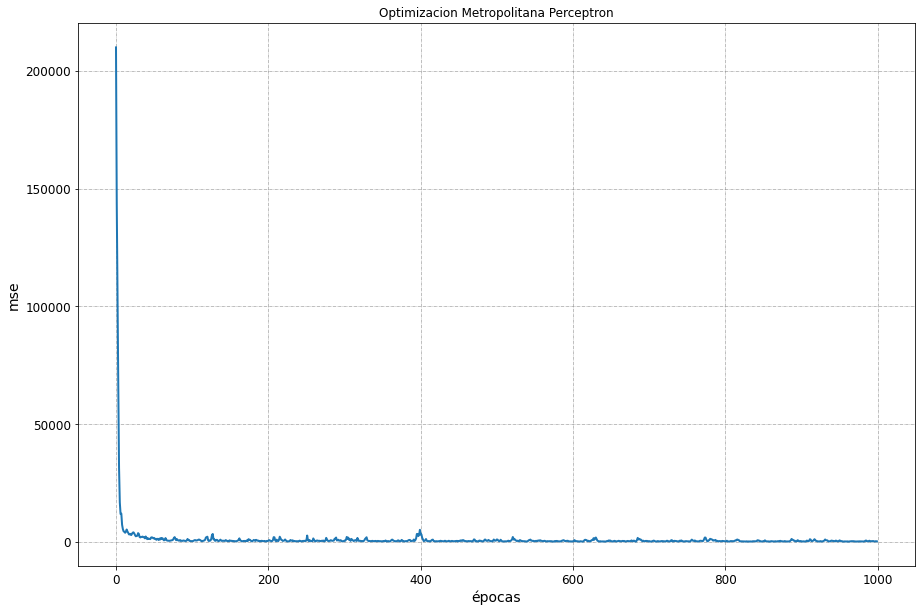

In [151]:
## Grafica Optimizacion
plt.figure(figsize=(15,10))
plt.plot(history.epoch,history.history['loss'], linewidth = 2)
plt.xlabel('épocas')
plt.ylabel('mse')
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.title('Optimizacion Metropolitana Perceptron')

In [152]:
# Estimate model performance
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

Train Score: 197.26 MSE (14.04 RMSE)
Test Score: 495.02 MSE (22.25 RMSE)


In [153]:
# generate predictions for training
trainPredict = np.squeeze(model.predict(x_train))
testPredict  = np.squeeze(model.predict(x_test))

Text(0.5, 1.0, 'Resultado Perceptron Metropolitana')

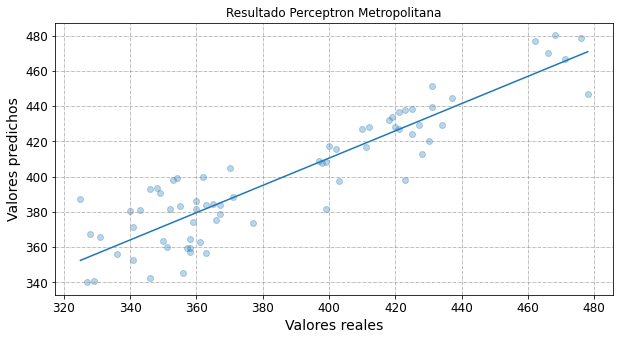

In [154]:
# Grafico Ajuste
plt.figure(figsize=(10,5))
plt.scatter(y_test,testPredict, alpha = 0.3)
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, testPredict, 1))(np.unique(y_test)))
plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.grid(color='grey', ls = '-.', lw = 0.5)
plt.title('Resultado Perceptron Metropolitana')

In [162]:
from datetime import datetime
fecha_hoy = datetime.now().strftime("%Y-%m-%d")
print(fecha_hoy)
idx_fecha_hoy = np.argwhere(fechas_test==fecha_hoy)[0] + len(trainPredict)

2021-03-07


IndexError: index 0 is out of bounds for axis 0 with size 0

In [163]:
fechas_test

array(['2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08',
       '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
       '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16',
       '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20',
       '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
       '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
       '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
       '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
       '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14',
       '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18',
       '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22',
       '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26',
       '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
       '2020-10-31', '2020-11-01', '2020-11-02', '2020-11-03',
       '2020-11-04', '2020-11-05', '2020-11-06', '2020-

NameError: name 'idx_fecha_hoy' is not defined

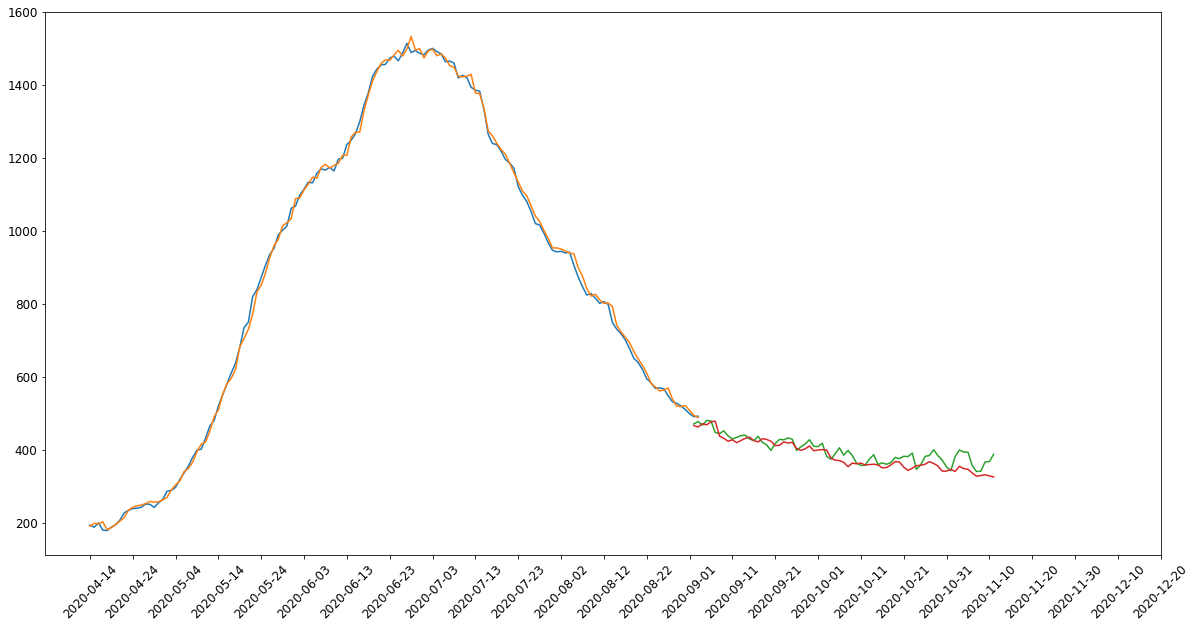

In [156]:
plt.figure(figsize=(20,10))
plt.plot(trainPredict,label="train_predict")
plt.plot(y_train,label="train")

puntos_base = np.arange(len(y_train),len(y_train)+len(y_test),1)-2
plt.plot(puntos_base,testPredict,label="test_predict")
plt.plot(puntos_base,y_test,label="test")
plt.xticks(np.arange(len(fechas))[::10],fechas[::10],rotation=45)
plt.axvline(idx_fecha_hoy,label="dias futuros",linestyle="--")
plt.grid(color='grey', ls = '-.', lw = 0.40)
plt.axvline(len(trainPredict),label="cambio train",linestyle="--",color="k")
plt.legend(fontsize = 12)
plt.xlabel('Fechas')
plt.ylabel('Cantidad')
plt.title('Proyección Perceptron Biobío')

## LSTM

In [ ]:
# # create and fit Multilayer Perceptron model
model = Sequential()
# model.add(Reshape((TIME_PERIODS, N_FEATURES), input_shape=(input_shape,)))
model.add(LSTM(50,  input_shape=(x_train[0].shape), return_sequences=True))
model.add(LSTM(50 ))
# model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(1, activation='relu'))
print(model.summary())

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(loss='mean_squared_error', optimizer=optimizer)
history = model.fit(x_train, y_train, epochs=1000, batch_size=batch_size, verbose=2, 
#                     callbacks=callbacks_list
                   )

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(history.epoch,history.history['loss'])
# plt.plot(history.epoch,history.history['val_loss'])
plt.title('Optimizacion')
plt.xlabel('epocas')
plt.ylabel('mse')
# plt.yscale("log")

In [ ]:
# Estimate model performance
trainScore = model.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, np.sqrt(trainScore)))
testScore = model.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, np.sqrt(testScore)))

In [ ]:
# generate predictions for training
trainPredict = np.squeeze(model.predict(x_train))
testPredict  = np.squeeze(model.predict(x_test))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(trainPredict,label="train_predict")
plt.plot(y_train,label="train")

puntos_base = np.arange(len(y_train),len(y_train)+len(y_test),1)-2
plt.plot(puntos_base,testPredict,label="test_predict")
plt.plot(puntos_base,y_test,label="test")
plt.legend()